# EBAC - Regressão II - regressão múltipla

## Tarefa I

#### Previsão de renda

Vamos trabalhar com a base 'previsao_de_renda.csv', que é a base do seu próximo projeto. Vamos usar os recursos que vimos até aqui nesta base.

|variavel|descrição|
|-|-|
|data_ref                | Data de referência de coleta das variáveis |
|index                   | Código de identificação do cliente|
|sexo                    | Sexo do cliente|
|posse_de_veiculo        | Indica se o cliente possui veículo|
|posse_de_imovel         | Indica se o cliente possui imóvel|
|qtd_filhos              | Quantidade de filhos do cliente|
|tipo_renda              | Tipo de renda do cliente|
|educacao                | Grau de instrução do cliente|
|estado_civil            | Estado civil do cliente|
|tipo_residencia         | Tipo de residência do cliente (própria, alugada etc)|
|idade                   | Idade do cliente|
|tempo_emprego           | Tempo no emprego atual|
|qt_pessoas_residencia   | Quantidade de pessoas que moram na residência|
|renda                   | Renda em reais|

In [167]:
import pandas as pd
import seaborn as sns
from seaborn import load_dataset

import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
import numpy as np

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

renda = pd.read_csv('previsao_de_renda.csv')
renda

,Unnamed: 0,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,0,2015-01-01,15056,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34
1,1,2015-01-01,9968,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15
2,2,2015-01-01,4312,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89
3,3,2015-01-01,10639,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77
4,4,2015-01-01,7064,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,2016-03-01,16006,F,False,True,0,Empresário,Secundário,Solteiro,Casa,48,13.887671,1.0,7990.58
14996,14996,2016-03-01,3722,F,False,True,0,Pensionista,Superior completo,Solteiro,Casa,57,NaN,1.0,10093.45
14997,14997,2016-03-01,6194,F,True,True,0,Assalariado,Superior completo,Casado,Casa,45,7.832877,2.0,604.82
14998,14998,2016-03-01,4922,M,True,False,0,Empresário,Superior completo,Casado,Casa,36,4.298630,2.0,3352.27


In [168]:
renda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             15000 non-null  int64  
 1   data_ref               15000 non-null  object 
 2   id_cliente             15000 non-null  int64  
 3   sexo                   15000 non-null  object 
 4   posse_de_veiculo       15000 non-null  bool   
 5   posse_de_imovel        15000 non-null  bool   
 6   qtd_filhos             15000 non-null  int64  
 7   tipo_renda             15000 non-null  object 
 8   educacao               15000 non-null  object 
 9   estado_civil           15000 non-null  object 
 10  tipo_residencia        15000 non-null  object 
 11  idade                  15000 non-null  int64  
 12  tempo_emprego          12427 non-null  float64
 13  qt_pessoas_residencia  15000 non-null  float64
 14  renda                  15000 non-null  float64
dtypes:

In [169]:
#Ajustando o DF
renda.drop(['Unnamed: 0','id_cliente'],axis = 1,inplace=True)
renda['tempo_emprego'].fillna(renda['tempo_emprego'].mean(),inplace=True)

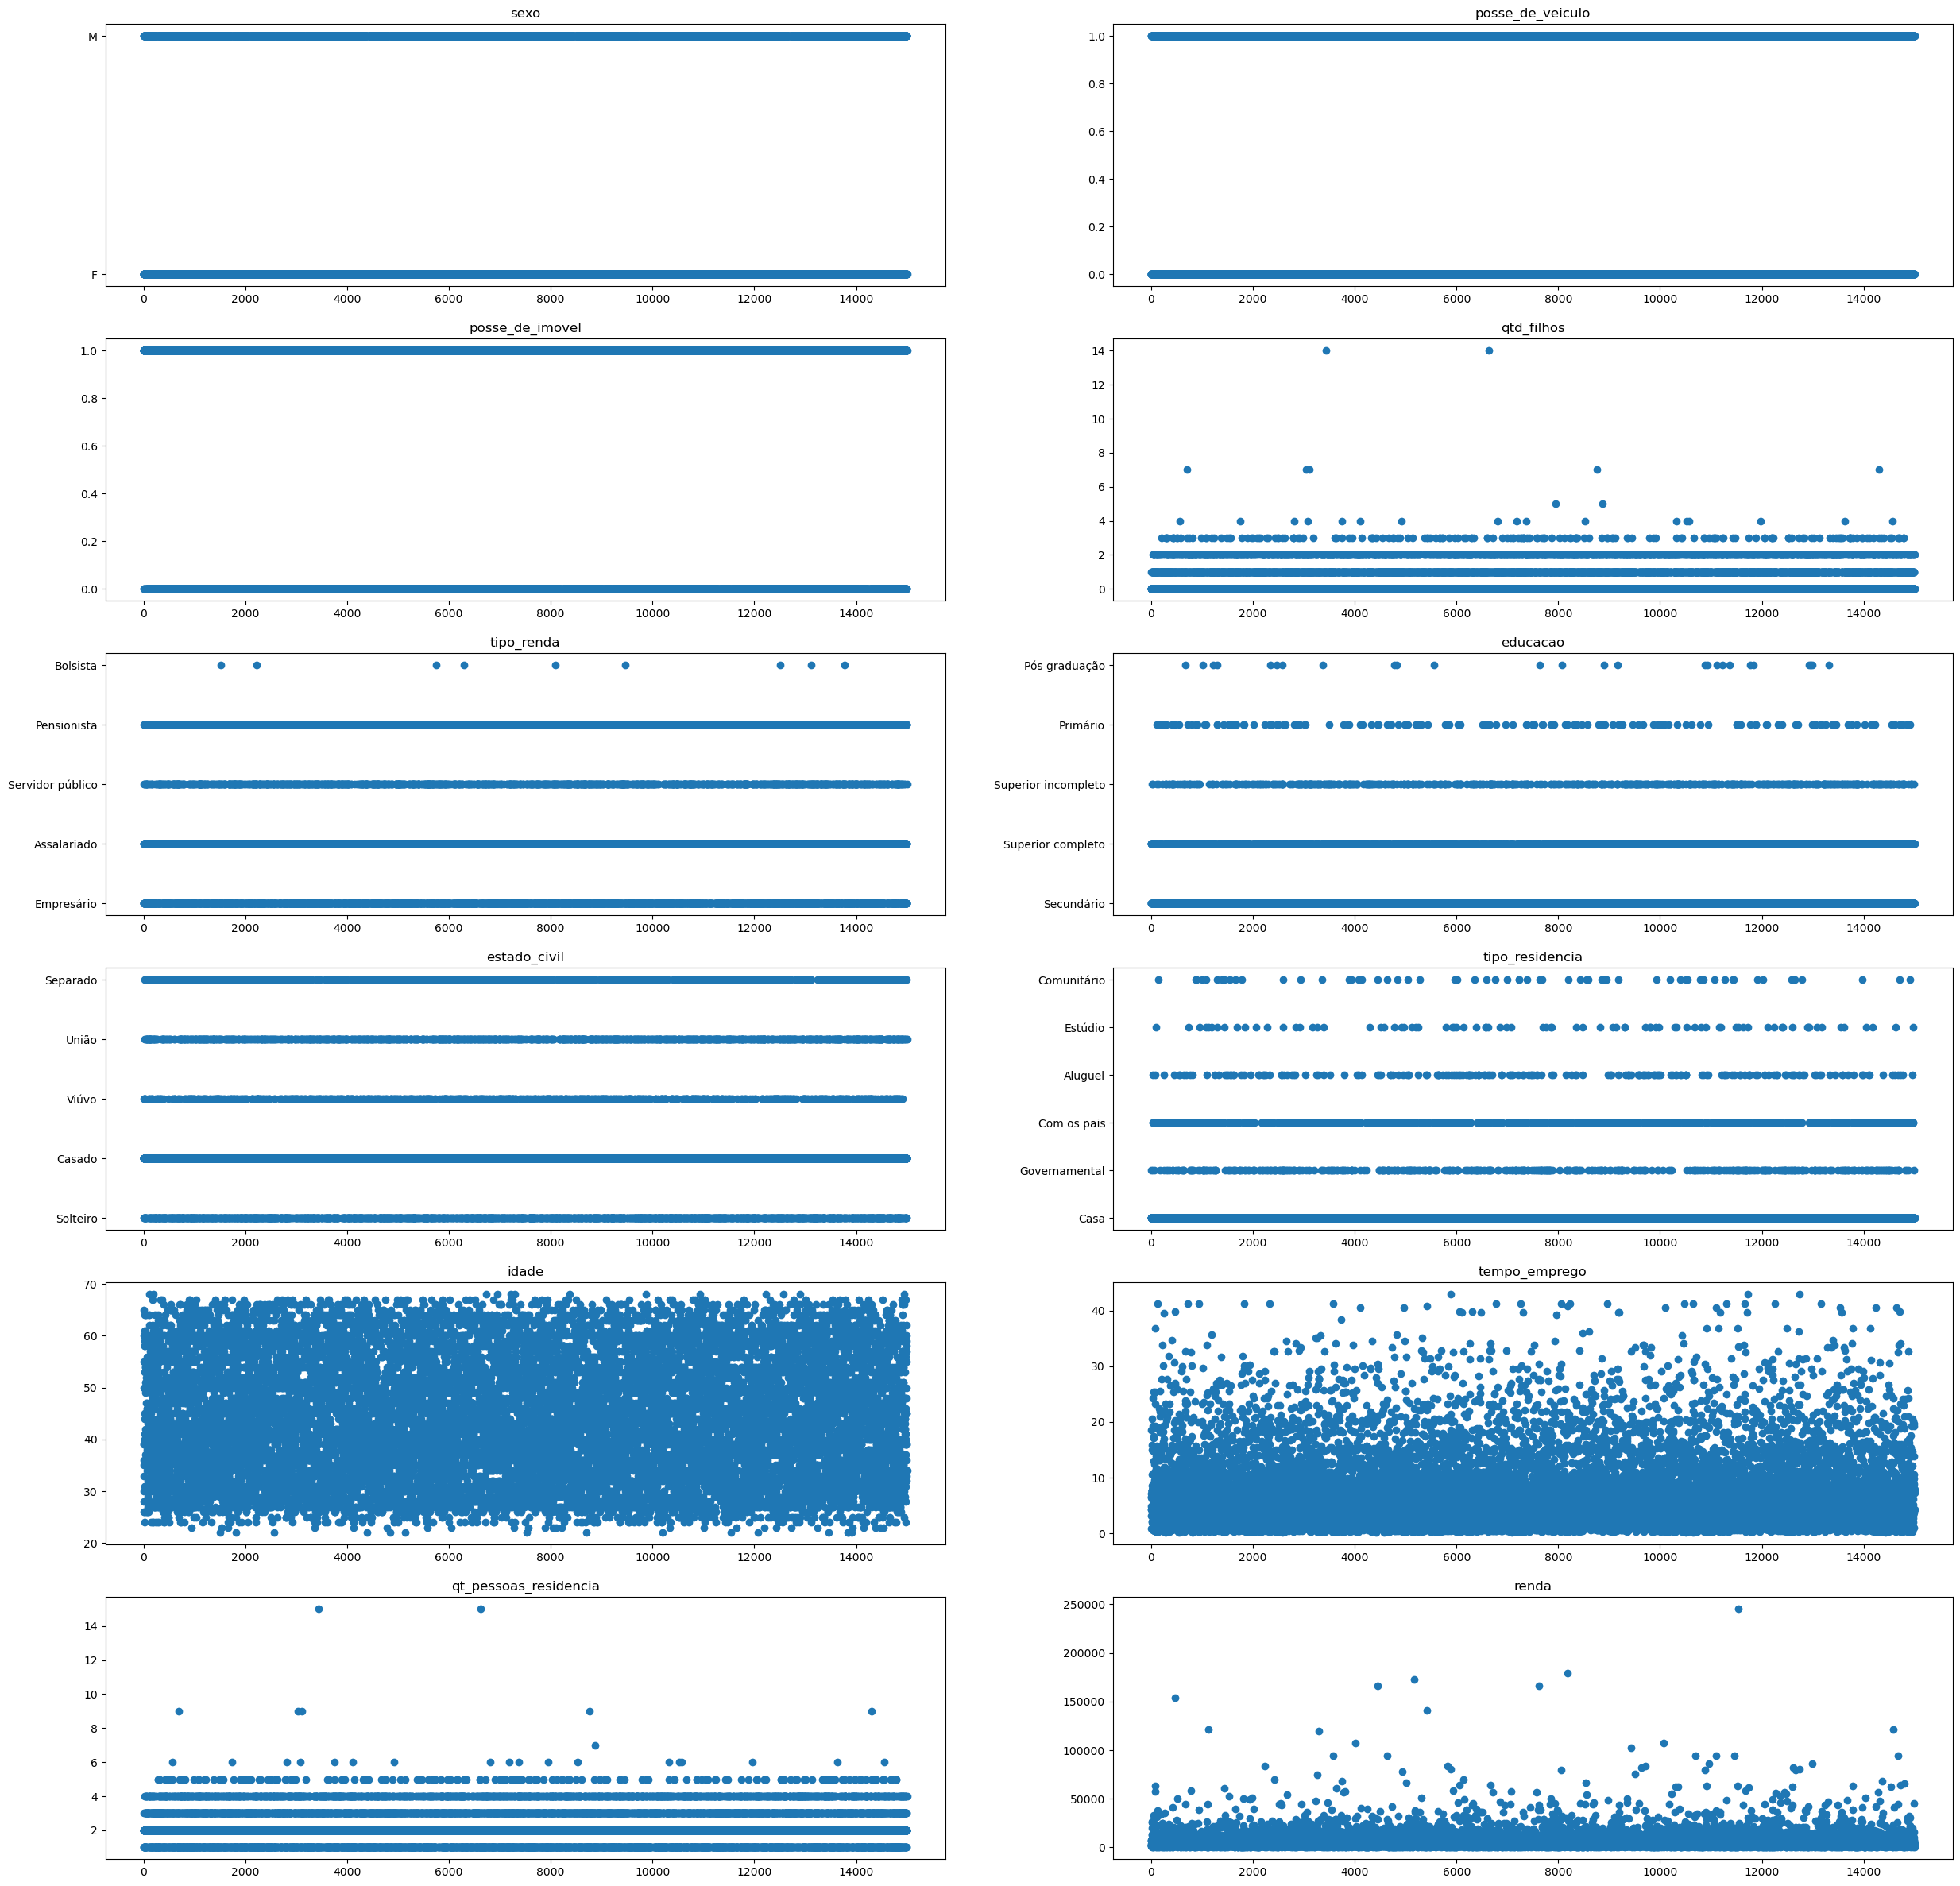

In [170]:
fig, axes = plt.subplots(nrows=((len(renda.columns)//2)), ncols=2, figsize=(30,30))
o = 0
b = 0
for i, col in enumerate(renda.drop('data_ref',axis = 1).columns):
        b = i//2
        axes[b,o].scatter(y = renda[col],x = renda.index)
        axes[b,o].set_title(col)
        if o == 0:
            o +=1
        else:
            o = 0
plt.show()

#agrupando qt_pessoas_residencia para uma melhor performance
bin_boundaries = [0, 1, 2, 4, float('inf')] 
bin_labels = ['1', '2', '3-4', '5+'] 
renda['qt_pessoas_residencia'] = pd.cut(renda['qt_pessoas_residencia'], bin_boundaries, labels=bin_labels)



#removendo outliers para o df de treino, rendas exorbitantes atrapalhariam a generalização do modelo
renda_train = renda.loc[renda['renda'] < 50000]



In [171]:
renda_train

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1,8060.34
1,2015-01-01,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2,1852.15
2,2015-01-01,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2,2253.89
3,2015-01-01,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3-4,6600.77
4,2015-01-01,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1,6475.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,2016-03-01,F,False,True,0,Empresário,Secundário,Solteiro,Casa,48,13.887671,1,7990.58
14996,2016-03-01,F,False,True,0,Pensionista,Superior completo,Solteiro,Casa,57,7.722635,1,10093.45
14997,2016-03-01,F,True,True,0,Assalariado,Superior completo,Casado,Casa,45,7.832877,2,604.82
14998,2016-03-01,M,True,False,0,Empresário,Superior completo,Casado,Casa,36,4.298630,2,3352.27


1. Ajuste um modelo para prever log(renda) considerando todas as covariáveis disponíveis.
    - Utilizando os recursos do Patsy, coloque as variáveis qualitativas como *dummies*.
    - Mantenha sempre a categoria mais frequente como casela de referência
    - Avalie os parâmetros e veja se parecem fazer sentido prático.

2. Remova a variável menos significante e analise:
    - Observe os indicadores que vimos, e avalie se o modelo melhorou ou piorou na sua opinião.
    - Observe os parâmetros e veja se algum se alterou muito.

3. Siga removendo as variáveis menos significantes, sempre que o *p-value* for menor que 5%. Compare o modelo final com o inicial. Observe os indicadores e conclua se o modelo parece melhor. 
    

Esse na minha opniao ficou o melhor modelo, onde os residuos somam

0.2560422509663959


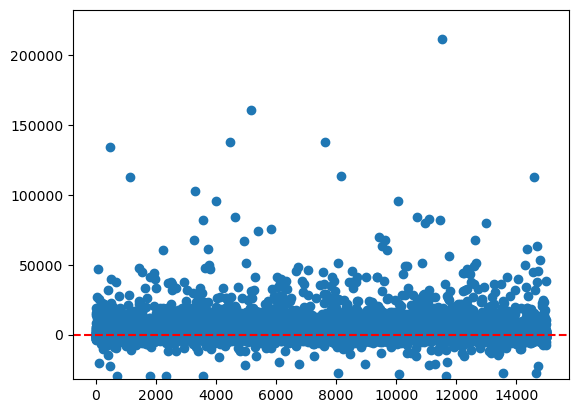

Residuos sem outliers, R2:0.21636492766676474


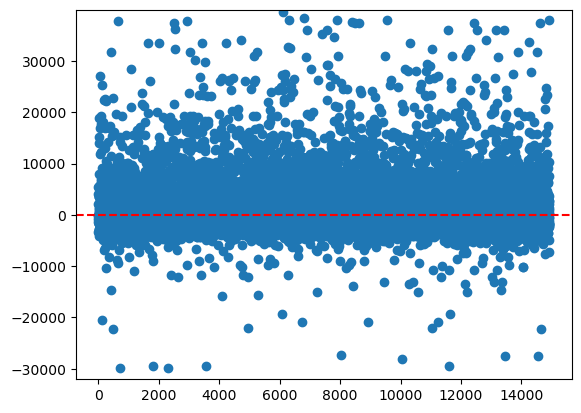

                            OLS Regression Results                            
Dep. Variable:          np.log(renda)   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     593.1
Date:                Mon, 15 May 2023   Prob (F-statistic):               0.00
Time:                        13:21:50   Log-Likelihood:                -16166.
No. Observations:               14920   AIC:                         3.236e+04
Df Residuals:                   14908   BIC:                         3.245e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

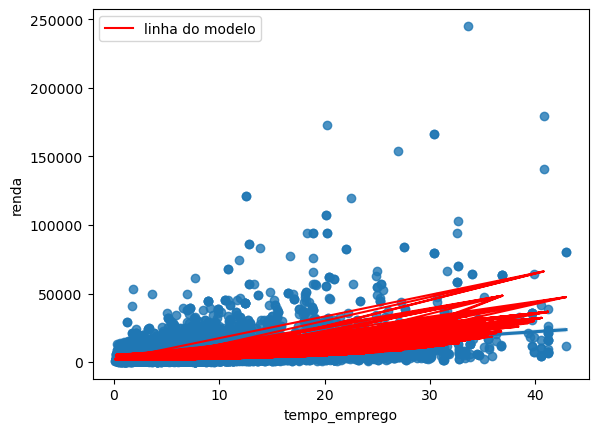

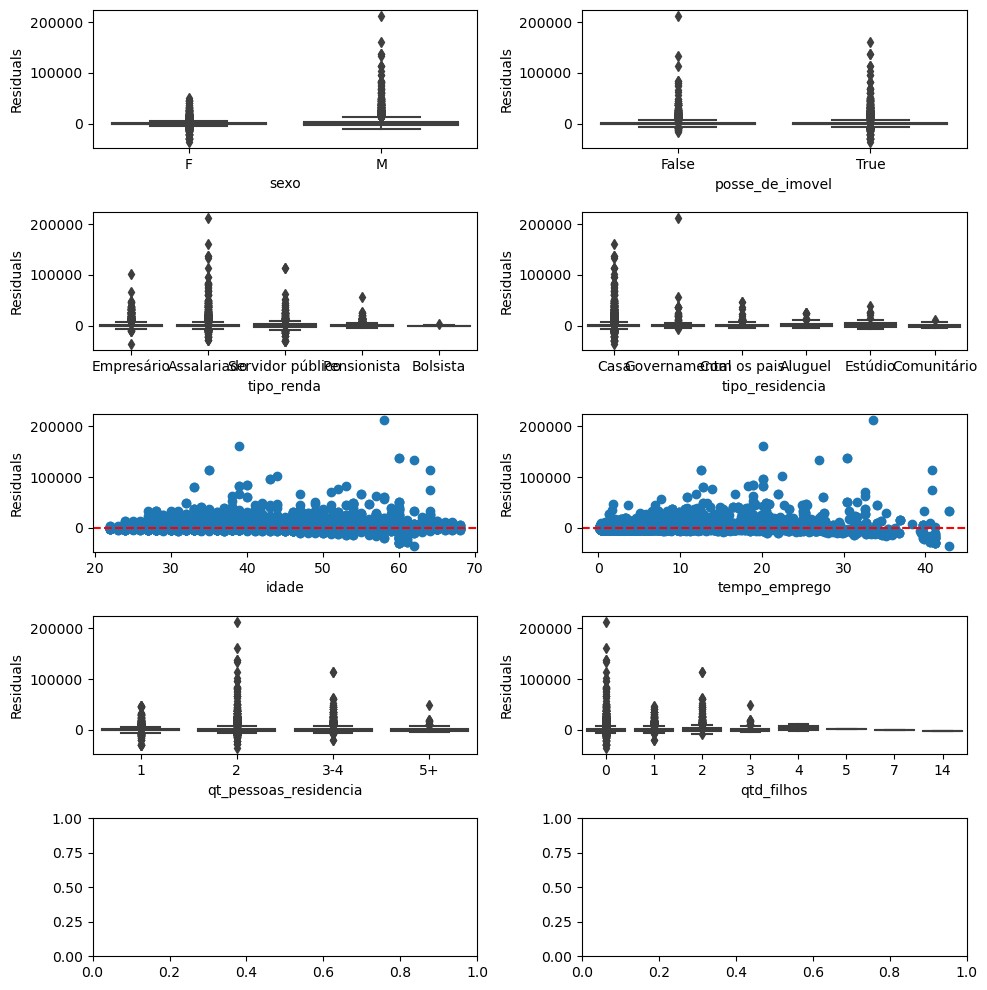

In [172]:
#ajustando os dados e removendo outliers
def op_y(y):
    return np.exp(y)
values = """np.log(renda) ~  sexo + posse_de_imovel + tipo_renda + C(qt_pessoas_residencia,Treatment(1))  + idade + I(tempo_emprego + np.power(tempo_emprego,1.5))"""
y_train, X_train = patsy.dmatrices(values, renda_train)
y_test, X_test = patsy.dmatrices(values,renda)
#colocando y_train no padrão da coluna apropriada
y_test = op_y(y_test)

#treinando o modelo
modelo = sm.OLS(y_train,X_train).fit()
y_pred = modelo.predict(X_test)

y_pred = op_y(y_pred)
y_train = op_y(y_train)

#obtendo o residuo manualmente, alguma alternativa para se conseguir esses dados para os dados preditos?
res = (np.ravel(y_test) - y_pred)
res_t = res.sum()

y_pred_m_trans = op_y(modelo.fittedvalues)
residuo_m_trans = np.ravel(y_train) - y_pred_m_trans

R2 = r2_score(np.ravel(y_test),y_pred)
R2_M = r2_score(np.ravel(y_train),y_pred_m_trans)

#plotando os residuos
plt.scatter(np.arange(len(res)),res)
plt.axhline(y=0, color='r', linestyle='--')
plt.ylim(res.min() - (res.min()/10),res.max() + (res.max()/10))
print(R2)
plt.show()

#plotando residuos sem outliers
plt.scatter(np.arange(len(residuo_m_trans)),residuo_m_trans)
plt.axhline(y=0, color='r', linestyle='--')
plt.ylim(residuo_m_trans.min() - 10*(residuo_m_trans.min()/100),residuo_m_trans.max() - 10*(residuo_m_trans.max()/100))
print(f'Residuos sem outliers, R2:{(R2_M)}')
plt.show()
print(modelo.summary())

#plotando o modelo
coluna = 'tempo_emprego'
sns.regplot(y = renda['renda'], x = renda[coluna])
x = renda[coluna]
y = (y_pred)
plt.plot(x, y, '-r', label='linha do modelo')
plt.legend()
plt.show()
#residuos por coluna
column = ['sexo','posse_de_imovel','tipo_renda','tipo_residencia' ,'idade' , 'tempo_emprego','qt_pessoas_residencia','qtd_filhos']
fig, axes = plt.subplots(nrows=((len(column)//2)+ 1), ncols=2, figsize=(10, 10))
o = 0
b = 0
for i, col in enumerate(column):
    if len(renda[col].value_counts()) > 20:
        b = i//2
        axes[b,o].scatter(x = renda[col], y = res)
        axes[b,o].set_xlabel(col)
        axes[b,o].set_ylabel('Residuals')
        axes[b,o].axhline(y=0, color='r', linestyle='--')
        if o == 0:
            o +=1
        else:
            o = 0
    else:
        b = i//2
        sns.boxplot(x = renda[col], y = res,ax = axes[b,o])
        axes[b,o].set_xlabel(col)
        axes[b,o].set_ylabel('Residuals')
        if o == 0:
            o +=1
        else:
            o = 0

plt.tight_layout()
plt.show()
#consideraçoes finais na ultima celula.

Depois de analizar e testar alguns modelos, esse teve resultados que considerei mais apropriados, o R2 Value qnd y no log é maior mas esse valor condiz mais com a realidade, outros modelos tiveram R2 maiores porem alguns com complexidade maior mas que os beneficios eram minimos e outros com R2 consideravelmente maiores mas tendiam a super extimar alguns salarios e isso em um ponto de vista economico poderia gerar prejuizos.